# Credit Card Fraud Detection System  
  
## Project Prototype
  
  
Author: Marco Fontana

<style>
    body {
        font-size: 20px;
    }
</style>

## **Implementation** 

Before starting code development, I prepared an environment that would allow me to write and test the code and track all the changes I made.   
The project is written in a Jupyter Notebook, in Python, and uses several third-party libraries specific to Machine Learning and Deep Learning algorithms.  
Therefore, before I could write code, I had to install all the necessary components on my PC's operating system

In [ ]:
# Install required libraries
!pip install numpy pandas tensorflow scikit-learn imbalanced-learn matplotlib

In [1]:
# Import required libraries
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-25 16:19:33.363037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:19:33.366292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:19:33.377396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737818373.394629   26311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737818373.399340   26311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 16:19:33.418034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### **Dataset analysis**

The first phase of the project is dedicated to the analysis of the dataset. Before proceeding to the implementation of the code, it is necessary to have a deep understanding of the available data in order to understand whether modifications are necessary to make the dataset suitable for ML and DL algorithms, thus increasing their performance.
Furthermore, since this dataset contains financial data, it is necessary to verify that there is no sensitive information of the user or payment institution, which could lead to confidentiality or ethical problems.

In the description of the dataset[] it is stated that for confidentiality reasons the content has been obscured via a PCA[] transformation; the feature name itself has been changed to a symbolic name (V1 to V28); the only features that have not been transformed or obfuscated are Time and Amount.  
The feature Time represents the number of seconds between each transaction and the first transaction, while Amount represents the amount of the transaction.  

Transforming and obfuscating the data and features of the dataset ensures that it does not contain sensitive information and guarantees that there are no confidentiality issues.

In [10]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Show dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset consists of 284807 records and is described by 31 features.  
The data are all of type float64, except for the feature 'Class' which is of type int64.

#### **Checking for missing values**

The next step is to check for missing values in the dataset.

In [3]:
print("\nNumber of missing values:", df.isnull().sum())


Number of missing values: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


The dataset contains no missing values, so no manual editing operation is required.  
  
By visualizing an example of the records in the dataset, I can understand whether other operations are needed on the data that can improve performance with the ML and DL algorithms.

In [4]:
# Display the first 5 records of the dataset
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


From the analysis of some records, it can be seen that the Time and Amount features have not been transformed.
The Time feature is not useful in my research, since it does not provide a particular pattern related to the transaction; I could transform it into a date and time value, but since I have no information about the time of the first transaction I would have to create non-real data; that is why I decided to remove it from the dataset.

In [5]:
df = df.drop(columns=['Time'])

The 'Amount' feature is of type int64 and the values it contains can vary widely between transactons.  
Some ML algorithms (SVM, gradient boosting, etc.) perform better when features are on a similar scale, and since the feature ‘Amount’ can have a significant variance, scaling helps stabilise the performance of the model.

I did not delete the 'Amount' feature because the economic value of the transaction can be of great importance for identifying fraud patterns.  

In [6]:
#Apply scaling to the 'Amount' feature
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

The StandardScaler is a data preprocessing technique commonly used in machine learning to scale or normalize features so that they have a mean of 0 and a standard deviation of 1. This is particularly important for many machine learning algorithms that are sensitive to the scale of input features, such as SVMs (Support Vector Machines), k-NN (k-Nearest Neighbors), and Logistic Regression. 
  
The state of the dataset after changes are made can be seen in the output below

In [7]:
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


The dataset description page contains information on the distrubution of its two classes two classes 'non-fraud' (0) and 'fraud' (1).  
The amount of records of the two types is very different, as can be seen in the following output.

In [12]:
# Convert the Class column to a NumPy array
class_array = df['Class'].to_numpy()

# Calculate the percentage of Class 1 records (frauds)
percentage_class_1 = (np.sum(class_array == 1) / len(class_array)) * 100

print(f"Percentage of Class 1 records: {percentage_class_1:.3f}%")

Percentage of Class 1 records: 0.173%


The large imbalance in the distribution of classes in the dataset is a problem for some ML and DL algorithms, and so it is necessary to use techniques for its balancing.

#### Balancing the dataset

To obtain a dataset with an equivalent number of records for its classes, I will use several techniques and then compare the results with ML and DL algorithms. The goal is to test which method generates synthetic data that most closely resembles real data; artificially generated data in fact could be classified as false negatives. By comparing the results I will be able to determine which of the balancing techniques is the most appropriate for generating this type of data.

The balancing of the dataset is done after its division into training and test data, so that the latter contain no ‘synthetic’ data.  

I created a class which uses several oversampling methods: SMOTE, ADASYN, Borderline-SMOTE, SVMSMOTE and Random Oversampling.  

In the following tests, these different techniques will be compared with ML and DL algorithms. I selected these techniques as a result of reading research in which they were used. In analyzing the results I will have to take into account the number of false positives, which also have an economic impact for the bank.

In [13]:
class OversamplingTechniques:
    def __init__(self, X, y):
        """
        Initialize the class with the original dataset features (X) and target (y).
        """
        self.X = X
        self.y = y
        self.results = {}

    def apply_smote(self):
        """
        Apply SMOTE to the dataset and save the oversampled dataset.
        """
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(self.X, self.y)
        self.results['SMOTE'] = (X_resampled, y_resampled)

    def apply_adasyn(self):
        """
        Apply ADASYN to the dataset and save the oversampled dataset.
        """
        adasyn = ADASYN(random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(self.X, self.y)
        self.results['ADASYN'] = (X_resampled, y_resampled)

    def apply_borderline_smote(self):
        """
        Apply Borderline-SMOTE to the dataset and save the oversampled dataset.
        """
        borderline_smote = BorderlineSMOTE(random_state=42)
        X_resampled, y_resampled = borderline_smote.fit_resample(self.X, self.y)
        self.results['Borderline-SMOTE'] = (X_resampled, y_resampled)

    def apply_svmsmote(self):
        """
        Apply SVMSMOTE to the dataset and save the oversampled dataset.
        """
        svmsmote = SVMSMOTE(random_state=42)
        X_resampled, y_resampled = svmsmote.fit_resample(self.X, self.y)
        self.results['SVMSMOTE'] = (X_resampled, y_resampled)

    def apply_random_oversampling(self):
        """
        Apply Random Oversampling to the dataset and save the oversampled dataset.
        """
        random_oversampler = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = random_oversampler.fit_resample(self.X, self.y)
        self.results['Random Oversampling'] = (X_resampled, y_resampled)

    def get_resampled_data(self, method):
        """
        Retrieve the resampled dataset for a given oversampling method.
        :param method: String indicating the oversampling method (e.g., 'SMOTE').
        :return: Tuple of resampled features (X) and target (y).
        """
        return self.results.get(method, None)


In [14]:
# Separate features and labels
X = df.drop(columns=['Class'])  # Features
y = df['Class']                 # Labels

# Split the data into train and test sets (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Class Distribution Before oversampling:
Class
0    284315
1       492
Name: count, dtype: int64


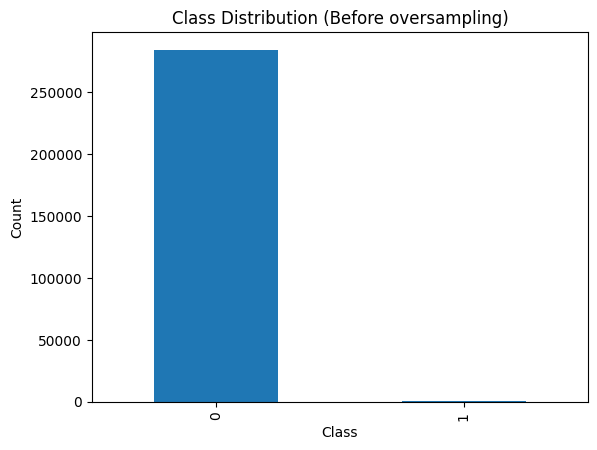

In [15]:
# Display class distribution before any oversampling technique is applied
print("Class Distribution Before oversampling:")
print(df['Class'].value_counts())
df['Class'].value_counts().plot(kind='bar', title='Class Distribution (Before oversampling)', xlabel='Class', ylabel='Count')
plt.show()

In [16]:
# Initialize the OversamplingTechniques class with training data
oversampling = OversamplingTechniques(X_train, y_train)

# Apply different oversampling techniques
oversampling.apply_smote()
oversampling.apply_adasyn()
oversampling.apply_borderline_smote()
oversampling.apply_svmsmote()
oversampling.apply_random_oversampling()

In [ ]:
# Apply SMOTE to balance the training data
smote_X, smote_y = oversampling.get_resampled_data('SMOTE')

# Check class distribution after SMOTE
print("Training Class Distribution After SMOTE:")
print(pd.Series(smote_y).value_counts())

# Visualize the balanced class distribution
pd.Series(smote_y).value_counts().plot(kind='bar', title='Class Distribution (After SMOTE)', xlabel='Class', ylabel='Count')
plt.show()

### Class for calculating the time taken to execute the code

In [ ]:
import time

class Timer:
    def __init__(self):
        """Initialize the timer with no start time"""
        self.start_time = None

    def start(self):
        """Start the timer"""
        self.start_time = time.time()        

    def elapsed(self):
        """Calculate the time elapsed since the timer was started"""
        if self.start_time is None:
            raise ValueError("Timer has not been started. Call `start()` before `elapsed()`")
        elapsed_time = time.time() - self.start_time
        return elapsed_time

    def stop(self):
        """Stop the timer and reset the start_time"""
        self.start_time = None

# Create the Timer object
timer = Timer()

In [ ]:
# Start the timer
timer.start()

# Train a Random Forest Classifier on the balanced dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

In [ ]:
# Start the timer
timer.start()

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

# Evaluate the model
print("Classification Report:\n", classification_report(y_pred, y_test))
print("Accuracy:", accuracy_score(y_pred, y_test))

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


In [ ]:
# Build the Autoencoder model
def build_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        # Encoder
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),  # Bottleneck (compressed representation)
        # Decoder
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')  # Output layer matches input
    ])
    return model

In [ ]:
# Separate features and labels
# The Class feature is not required in an unsupervised learning model
X = df.drop(columns=['Class'], axis=1)  # Features
y = df['Class']  # Labels

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Separate normal (non-fraudulent) transactions for training the Autoencoder
X_normal = X_normalized[y == 0]

# Split the normal transactions into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Initialize the Autoencoder
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Start the timer
timer.start()

# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,  # Input is the same as the target
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=64,
    verbose=1
)   

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Use the Autoencoder to calculate reconstruction errors
X_reconstructed = autoencoder.predict(X_normalized)
reconstruction_errors = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Set a threshold for anomalies based on normal transactions' errors
threshold = np.percentile(reconstruction_errors[y == 0], 99)  # 98th percentile

# Classify anomalies (fraud) based on reconstruction error
y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluate the results
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))

# Visualize reconstruction error distributions
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_errors[y == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_errors[y == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

In [ ]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()